In [1]:
# ipython settings
%load_ext autoreload
%autoreload 2

In [2]:
# imports
import sys
sys.path.append('../BioExp')
import keras
import numpy as np
import tensorflow as tf
from keras.models import load_model
import pandas as pd
import os
import pickle

from keras.backend.tensorflow_backend import set_session
from BioExp.helpers.metrics import *
from BioExp.helpers.losses import *

Using TensorFlow backend.


In [3]:
!export CUDA_VISIBLE_DEVICES=-1

In [4]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [4]:
# GPU setup
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))

In [5]:
# model and parameter defn
# currently using simple U-net

seq_map = {'flair': 0, 't1': 1, 't2': 3, 't1c':2}
seq = 'flair'

model_path        = './saved_models/Brats_{}/model-archi.h5'.format(seq)
weights_path      = './saved_models/Brats_{}/model-wts-{}.hdf5'.format(seq, seq)

# layers_to_consider = ['conv2d_2', 'conv2d_3', 'conv2d_4', 'conv2d_5', 'conv2d_6','conv2d_7', 'conv2d_8', 'conv2d_9',\
#                       'conv2d_10', 'conv2d_11', 'conv2d_12', 'conv2d_13', 'conv2d_14', 'conv2d_15', 'conv2d_16',\
#                        'conv2d_17','conv2d_18', 'conv2d_19', 'conv2d_20', 'conv2d_21']


layers_to_consider = ['conv2d_2', 'conv2d_5','conv2d_7',  'conv2d_9', 'conv2d_11', \
                      'conv2d_13', 'conv2d_15','conv2d_17', 'conv2d_19', 'conv2d_20', 'conv2d_21']

model = load_model(model_path, custom_objects={'gen_dice_loss':gen_dice_loss,
                                'dice_whole_metric':dice_whole_metric,
                                'dice_core_metric':dice_core_metric,
                                'dice_en_metric':dice_en_metric})
model.load_weights(weights_path)


In [6]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 240, 240, 1)       0         
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 240, 240, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 240, 240, 64)      320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 240, 240, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 240, 240, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 240, 240, 64)      36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 240, 240, 64)      256 

In [6]:
from BioExp.clusters import clusters

concept_info = []
node = 0

save_root = './LogsN/{}/weights_cluster/'.format(seq)
for i, layer_name in enumerate(layers_to_consider):
    save_path = os.path.join(save_root, layer_name)
    os.makedirs(save_path, exist_ok = True)
    
    C = clusters.Cluster(model, weights_path, layer_name)
    labels = C.get_clusters(threshold = .50, 
                            normalize = True,
                            position  = True,
                            save_path = save_path)
    C.plot_weights(labels, os.path.join(save_path, 'wt-samples'))
    
    for label in np.unique(labels):
        nodename = 'node_{}'.format(node)
        layername = layer_name
        fidxs = np.where(labels==label)[0]
        info = {'concept_name': nodename, 
                  'layer_name': layername, 
                 'filter_idxs': fidxs,
                 'node_order': i}
        concept_info.append(info)
        node += 1
        
with open(os.path.join(save_root, 'cluster_info.cpickle'), 'wb') as file:
    pickle.dump(concept_info, file)

[INFO: BioExp Clustering] Layer: conv2d_2, Nclusters: 3, Labels: [0 1 2], Freq. of each labels: [30, 21, 13] Clustering Score: 0.07355802827437044
[INFO: BioExp Clustering] Layer: conv2d_5, Nclusters: 4, Labels: [0 1 2 3], Freq. of each labels: [70, 32, 10, 16] Clustering Score: 0.14081232265986485
[INFO: BioExp Clustering] Layer: conv2d_7, Nclusters: 4, Labels: [0 1 2 3], Freq. of each labels: [94, 65, 58, 39] Clustering Score: 0.1445049656569059
[INFO: BioExp Clustering] Layer: conv2d_9, Nclusters: 3, Labels: [0 1 2], Freq. of each labels: [89, 68, 99] Clustering Score: 0.08001253549272735
[INFO: BioExp Clustering] Layer: conv2d_11, Nclusters: 3, Labels: [0 1 2], Freq. of each labels: [165, 268, 79] Clustering Score: 0.09236398859020195
[INFO: BioExp Clustering] Layer: conv2d_13, Nclusters: 3, Labels: [0 1 2], Freq. of each labels: [120, 72, 64] Clustering Score: 0.13362113364673717
[INFO: BioExp Clustering] Layer: conv2d_15, Nclusters: 3, Labels: [0 1 2], Freq. of each labels: [131,

/home/pi/miniconda/envs/bioexp/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


----------
### TODO

Another proposed method for clustering is to hand-engineered features using statistical methods. We carefully select features responsible for orientations, intensity, and textures using statistical tricks, which are further used by GMM's for grouping them together. 

- [ ] Different clustering methods by hand engineered features
- [x] Features considered currently, which in combination provides transforms any weight tensor to vector $\in \mathbb{R}^{32\times 1}$
        - Orientation features
        - Energy features
        - Texture features

This method still needs some thoughts to make it work as expected, which will be explored in future works. As the clusters formed are still in expectational sense, which results in loss of information which inturn makes it hard to form well seperated clusters.

#### GradCAM revist
![cam](./imgs/gradcam.png)

-----


In [7]:
from BioExp.clusters.concept import ConceptIdentification
from BioExp.helpers import utils

image, gt = utils.load_vol_brats('../BioExp/sample_vol/brats/Brats18_CBICA_AOP_1', slicen=105)
image = image[:, :, seq_map[seq]][:,:, None]

save_root = './Logs/{}/weights_cluster/'.format(seq)
with open(os.path.join(save_root, 'cluster_info.cpickle'), 'rb') as file:
    concepts_info = pickle.load(file)
    
metric = dice_label_coef # defined in helpers.losses
identifier = ConceptIdentification(model, weights_path, metric)

save_root = './Logs/{}/concept_identificationN'.format(seq)

# restart = ['conv2d_19', 'conv2d_20', 'conv2d_21']
for concept_info in concepts_info:
#     if not (concept_info['layer_name'] in restart): continue
    identifier.flow_based_identifier(concept_info, 
                           save_path = os.path.join(save_root, 
                                            concept_info['layer_name']), 
                           test_img = image)
    
#     identifier.check_robustness(concept_info,
#                             save_path = os.path.join(save_root, 
#                                                      concept_info['layer_name']), 
#                             test_img = image,
#                             save_all = True,
#                             nmontecarlo = 10)

/home/pi/miniconda/envs/bioexp/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


/home/pi/miniconda/envs/bioexp/lib/python3.6/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/pi/miniconda/envs/bioexp/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


[INFO: BioExp Concept Identification] Identified Concept node_0 in layer conv2d_2
[INFO: BioExp Concept Identification] Identified Concept node_1 in layer conv2d_2
[INFO: BioExp Concept Identification] Identified Concept node_2 in layer conv2d_2
[INFO: BioExp Concept Identification] Identified Concept node_3 in layer conv2d_5
[INFO: BioExp Concept Identification] Identified Concept node_4 in layer conv2d_5
[INFO: BioExp Concept Identification] Identified Concept node_5 in layer conv2d_5
[INFO: BioExp Concept Identification] Identified Concept node_6 in layer conv2d_5
[INFO: BioExp Concept Identification] Identified Concept node_7 in layer conv2d_7
[INFO: BioExp Concept Identification] Identified Concept node_8 in layer conv2d_7
[INFO: BioExp Concept Identification] Identified Concept node_9 in layer conv2d_7
[INFO: BioExp Concept Identification] Identified Concept node_10 in layer conv2d_7
[INFO: BioExp Concept Identification] Identified Concept node_11 in layer conv2d_9
[INFO: BioExp 

In [8]:
# consistence test
from BioExp.clusters.concept import ConceptIdentification
from BioExp.helpers import utils


save_root = './Logs/{}/weights_cluster/'.format(seq)
with open(os.path.join(save_root, 'cluster_info.cpickle'), 'rb') as file:
    concepts_info = pickle.load(file)
    
metric = dice_label_coef # defined in helpers.losses
identifier = ConceptIdentification(model, weights_path, metric)

selected_nodes = ['node_28', 'node_30', 'node_32']
selected_images = ['Brats18_CBICA_AOP_1', 'Brats18_CBICA_ATD_1','Brats18_CBICA_ATB_1', 'Brats18_CBICA_AOZ_1', 'Brats18_CBICA_ASY_1']

for img in selected_images: 
    save_root = './Logs_consistenceNN/{}/concept_identification/{}/'.format(seq, img)

    image, gt = utils.load_vol_brats('../BioExp/sample_vol/brats/{}'.format(img), slicen=105)
    image = image[:, :, seq_map[seq]][:,:, None]
    for concept_info in concepts_info:
        if not (concept_info['concept_name'] in selected_nodes): continue
        identifier.flow_based_identifier(concept_info, 
                               save_path = os.path.join(save_root), 
                               test_img = image)

[INFO: BioExp Concept Identification] Identified Concept node_28 in layer conv2d_19
[INFO: BioExp Concept Identification] Identified Concept node_30 in layer conv2d_19
[INFO: BioExp Concept Identification] Identified Concept node_32 in layer conv2d_20
[INFO: BioExp Concept Identification] Identified Concept node_28 in layer conv2d_19
[INFO: BioExp Concept Identification] Identified Concept node_30 in layer conv2d_19
[INFO: BioExp Concept Identification] Identified Concept node_32 in layer conv2d_20
[INFO: BioExp Concept Identification] Identified Concept node_28 in layer conv2d_19
[INFO: BioExp Concept Identification] Identified Concept node_30 in layer conv2d_19
[INFO: BioExp Concept Identification] Identified Concept node_32 in layer conv2d_20
[INFO: BioExp Concept Identification] Identified Concept node_28 in layer conv2d_19
[INFO: BioExp Concept Identification] Identified Concept node_30 in layer conv2d_19
[INFO: BioExp Concept Identification] Identified Concept node_32 in layer co

In [9]:
# Robustness tet

from BioExp.clusters.concept import ConceptIdentification
from BioExp.helpers import utils

image, gt = utils.load_vol_brats('../BioExp/sample_vol/brats/Brats18_CBICA_AOP_1', slicen=105)
image = image[:, :, seq_map[seq]][:,:, None]

save_root = './Logs/{}/weights_cluster/'.format(seq)
with open(os.path.join(save_root, 'cluster_info.cpickle'), 'rb') as file:
    concepts_info = pickle.load(file)
    
metric = dice_label_coef # defined in helpers.losses
identifier = ConceptIdentification(model, weights_path, metric)

save_root = './Logs_robustnessNN/{}/concept_identification'.format(seq)

for concept_info in concepts_info:   
    if not (concept_info['concept_name'] == 'node_30'): continue
    identifier.check_robustness(concept_info,
                            save_path = os.path.join(save_root, 'basegaussian'), 
                            test_img = image,
                            save_all = True,
                            nmontecarlo = 4,
                            base = True,
                            compare =True,
                            prior = 'gaussian')
    identifier.check_robustness(concept_info,
                            save_path = os.path.join(save_root, 'baseuniform'), 
                            test_img = image,
                            save_all = True,
                            nmontecarlo = 4,
                            base = True,
                            compare =True,
                            prior = 'uniform')
    identifier.check_robustness(concept_info,
                            save_path = os.path.join(save_root, 'gaussian'), 
                            test_img = image,
                            save_all = True,
                            nmontecarlo = 4,
                            compare = True,
                            prior = 'gaussian')
    identifier.check_robustness(concept_info,
                            save_path = os.path.join(save_root, 'uniform'), 
                            test_img = image,
                            save_all = True,
                            nmontecarlo = 4,
                            compare = True,
                            prior = 'uniform')

[INFO: BioExp Concept Identification] Identified Concept node_30 in layer conv2d_19
[INFO: BioExp Concept Robustness] Difference in Score 0.007885373197495937
[INFO: BioExp Concept Identification] Identified Concept node_30 in layer conv2d_19
[INFO: BioExp Concept Robustness] Difference in Score 0.007886282168328762
[INFO: BioExp Concept Identification] Identified Concept node_30 in layer conv2d_19
[INFO: BioExp Concept Robustness] Difference in Score 0.007886259816586971
[INFO: BioExp Concept Identification] Identified Concept node_30 in layer conv2d_19
[INFO: BioExp Concept Robustness] Difference in Score 0.007886162027716637


=========./Logs/flair/concept_identificationN/conv2d_11/node_14.png========


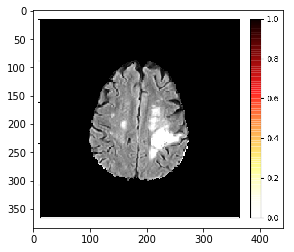

=========./Logs/flair/concept_identificationN/conv2d_11/node_15.png========


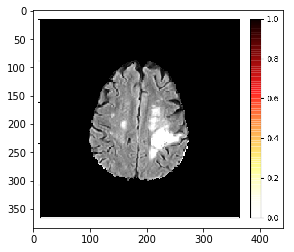

=========./Logs/flair/concept_identificationN/conv2d_11/node_16.png========


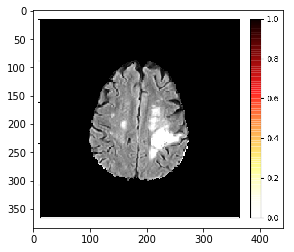

=========./Logs/flair/concept_identificationN/conv2d_13/node_17.png========


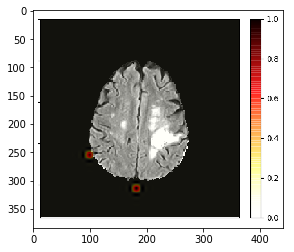

=========./Logs/flair/concept_identificationN/conv2d_13/node_18.png========


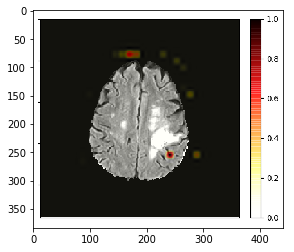

=========./Logs/flair/concept_identificationN/conv2d_13/node_19.png========


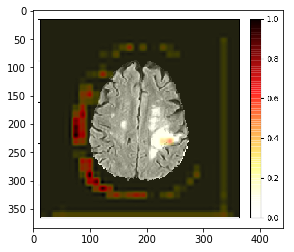

=========./Logs/flair/concept_identificationN/conv2d_15/node_20.png========


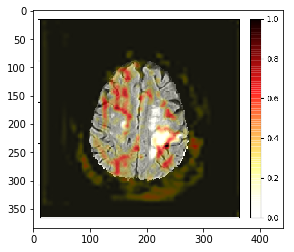

=========./Logs/flair/concept_identificationN/conv2d_15/node_21.png========


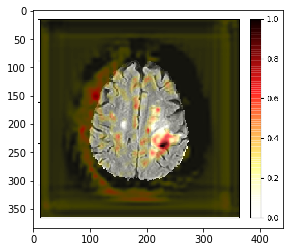

=========./Logs/flair/concept_identificationN/conv2d_15/node_22.png========


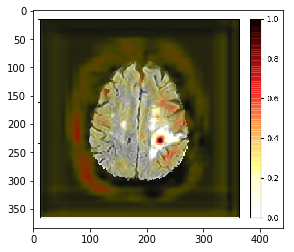

=========./Logs/flair/concept_identificationN/conv2d_17/node_23.png========


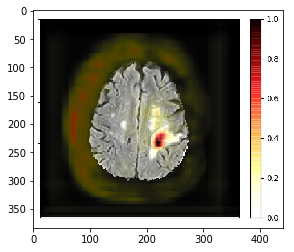

=========./Logs/flair/concept_identificationN/conv2d_17/node_24.png========


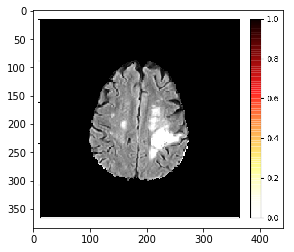

=========./Logs/flair/concept_identificationN/conv2d_17/node_25.png========


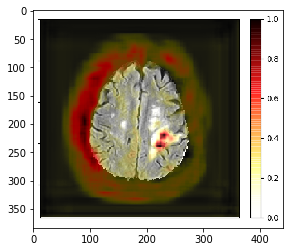

=========./Logs/flair/concept_identificationN/conv2d_17/node_26.png========


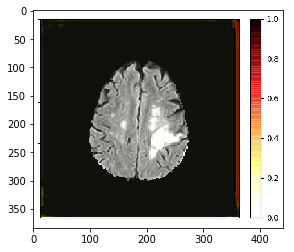

=========./Logs/flair/concept_identificationN/conv2d_19/node_27.png========


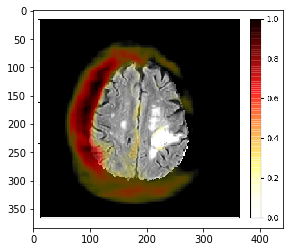

=========./Logs/flair/concept_identificationN/conv2d_19/node_28.png========


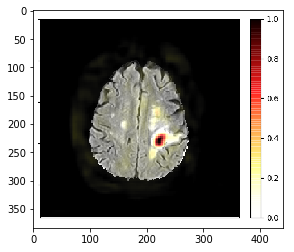

=========./Logs/flair/concept_identificationN/conv2d_19/node_29.png========


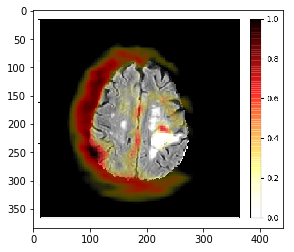

=========./Logs/flair/concept_identificationN/conv2d_19/node_30.png========


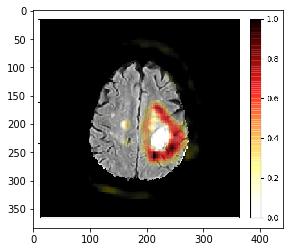

=========./Logs/flair/concept_identificationN/conv2d_19/node_31.png========


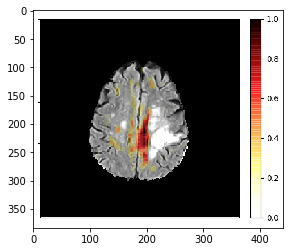

=========./Logs/flair/concept_identificationN/conv2d_2/node_0.png========


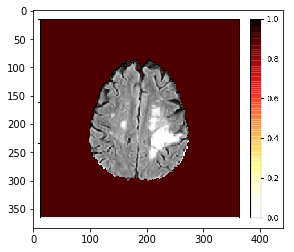

=========./Logs/flair/concept_identificationN/conv2d_2/node_1.png========


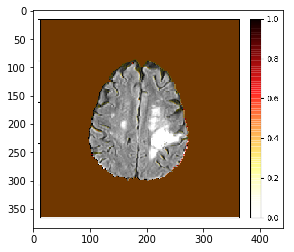

=========./Logs/flair/concept_identificationN/conv2d_2/node_2.png========


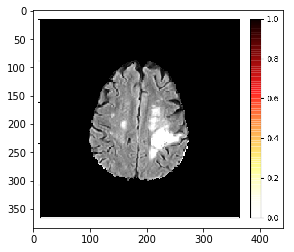

=========./Logs/flair/concept_identificationN/conv2d_20/node_32.png========


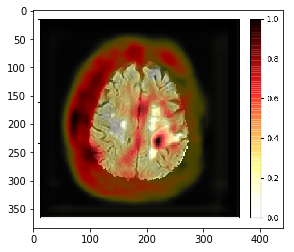

=========./Logs/flair/concept_identificationN/conv2d_20/node_33.png========


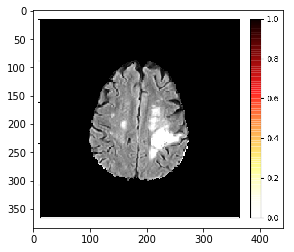

=========./Logs/flair/concept_identificationN/conv2d_21/node_34.png========


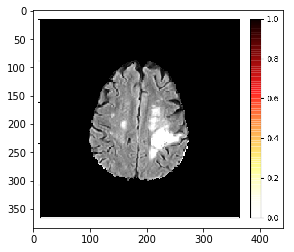

=========./Logs/flair/concept_identificationN/conv2d_21/node_35.png========


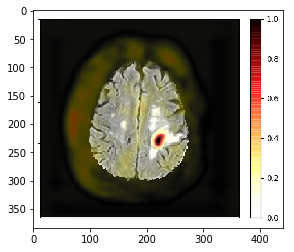

=========./Logs/flair/concept_identificationN/conv2d_21/node_36.png========


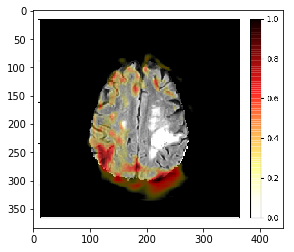

=========./Logs/flair/concept_identificationN/conv2d_5/node_3.png========


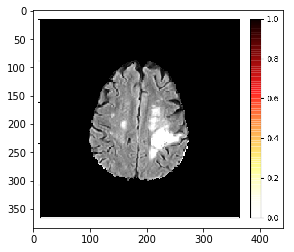

=========./Logs/flair/concept_identificationN/conv2d_5/node_4.png========


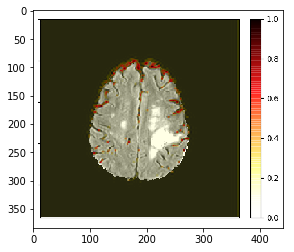

=========./Logs/flair/concept_identificationN/conv2d_5/node_5.png========


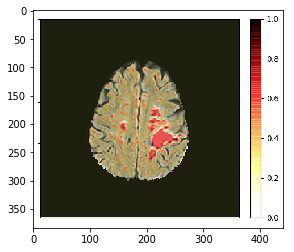

=========./Logs/flair/concept_identificationN/conv2d_5/node_6.png========


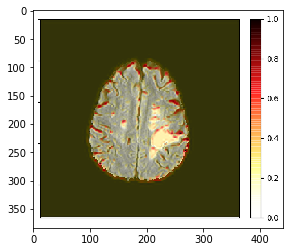

=========./Logs/flair/concept_identificationN/conv2d_7/node_10.png========


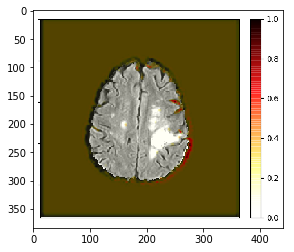

=========./Logs/flair/concept_identificationN/conv2d_7/node_7.png========


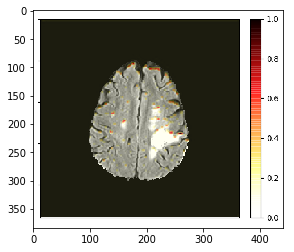

=========./Logs/flair/concept_identificationN/conv2d_7/node_8.png========


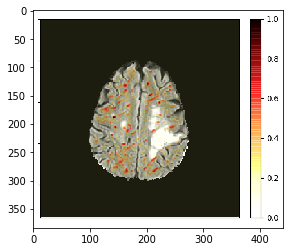

=========./Logs/flair/concept_identificationN/conv2d_7/node_9.png========


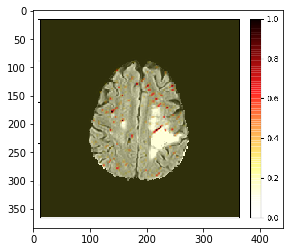

=========./Logs/flair/concept_identificationN/conv2d_9/node_11.png========


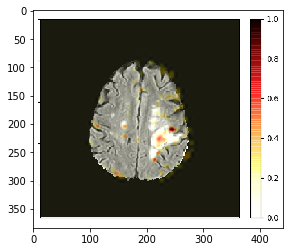

=========./Logs/flair/concept_identificationN/conv2d_9/node_12.png========


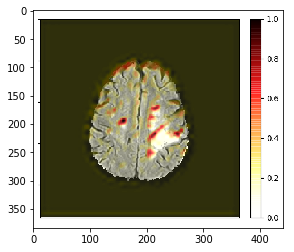

=========./Logs/flair/concept_identificationN/conv2d_9/node_13.png========


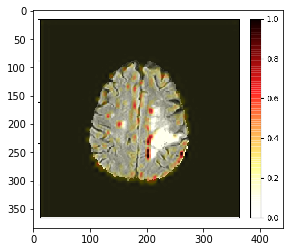

In [10]:
from glob import glob
from PIL import Image
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

save_root = './Logs/{}/concept_identificationN'.format(seq)
paths = np.array([pth for pth in glob(save_root + '/*/*.png') if not pth.__contains__('robustness')])
for pth in paths:
    print ("========={}========".format(pth))
    plt.imshow(np.array(Image.open(pth)))
    plt.show()


In [11]:
# Concept Robustness results

from glob import glob
from PIL import Image
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

save_root = './LogsN/{}/concept_identificationN'.format(seq)
paths = np.array([pth for pth in glob(save_root + '/*/*.png') if pth.__contains__('robustness')])
for pth in paths:
    print ("========={}========".format(pth))
    plt.imshow(np.array(Image.open(pth)))
    plt.show()

In [11]:
# These descriptions are provided manually by the user, 
# based on the way he/she interprets above images
# In this case we use atlas to obtain proper description


from pprint import pprint
consider_nodes = [{'node': 14, 'description': 'Lateral right hemispherical brain boundary'}, 
                  {'node': 19, 'description': 'Lateral left hemispherical brain boundary'}, 
                  {'node': 20, 'description': 'Anterior tumor region along with medial mid brain region'},
                  {'node': 21, 'description': 'Left lateral tumor region'},
                  {'node': 28, 'description': 'Eroded tumor core region'},
                  {'node': 35, 'description': 'Dilated tumor core region'},
                  {'node': 25, 'description': 'Anterior tumor region along with Lateral left hemispherical brain boundary'},
                  {'node': 29, 'description': 'Tumor core boundary along with Lateral left hemispherical brain boundary'},
                  {'node': 30, 'description': 'Whole tumor boundary and edima region'},
                  {'node': 4, 'description': 'Concave edge detector'},
                  {'node': 5, 'description': 'Convex edge deector'},
                  {'node': 6, 'description': 'Horizontal edge detectors'},
                  {'node': 10, 'description': 'Tumor Corner keypoints'},
                  {'node': 8, 'description': 'Corner keypoints all over the brain'},
                  {'node': 9, 'description': 'Corner keypoints in the tumor hemisphere brain'},
                  {'node': 13, 'description': 'Anterior brain boundary and inner brain corner keypoints'},
                ]

# update cluster info
save_root = './LogsN/{}/weights_cluster/'.format(seq)
with open(os.path.join(save_root, 'cluster_info.cpickle'), 'rb') as file:
    concepts_info = pickle.load(file)
    
modified_concepts = []
for concept_info in concepts_info:
    for i, node in enumerate(consider_nodes):
        if node['node'] == int(concept_info['concept_name'].split('_').pop()):
            concept_info['description'] = consider_nodes[i]['description']
            pprint(concept_info)
            modified_concepts.append(concept_info)
            break

with open('./LogsN/{}/modified_clusters.cpickle'.format(seq), 'wb') as file:
    pickle.dump(modified_concepts, file)  

{'concept_name': 'node_4',
 'description': 'Concave edge detector',
 'filter_idxs': array([  0,   3,   4,  10,  12,  13,  16,  20,  29,  30,  33,  34,  39,
        42,  44,  49,  59,  63,  64,  66,  71,  75,  77,  85,  89,  90,
        94,  96, 109, 112, 117, 118]),
 'layer_name': 'conv2d_5',
 'node_order': 1}
{'concept_name': 'node_5',
 'description': 'Convex edge deector',
 'filter_idxs': array([  5,   7,  25,  32,  40,  50,  81, 111, 115, 116]),
 'layer_name': 'conv2d_5',
 'node_order': 1}
{'concept_name': 'node_6',
 'description': 'Horizontal edge detectors',
 'filter_idxs': array([ 22,  26,  27,  28,  45,  57,  61,  65,  74,  82,  91,  98,  99,
       101, 107, 125]),
 'layer_name': 'conv2d_5',
 'node_order': 1}
{'concept_name': 'node_8',
 'description': 'Corner keypoints all over the brain',
 'filter_idxs': array([  0,   5,   6,  14,  15,  28,  35,  36,  40,  45,  47,  51,  52,
        53,  61,  62,  65,  73,  74,  76,  77,  78,  85,  86,  91,  97,
        98, 108, 112, 116, 118,

In [ ]:
from BioExp.graphs.causal import CausalGraph
from BioExp.helpers import utils

metric = dice_label_coef # defined in helpers.losses
CG = CausalGraph(model, weights_path, metric)


with open('./LogsN/{}/modified_clusters.cpickle'.format(seq), 'rb') as file:
    concept_info = pickle.load(file)

dataset_path = '../BioExp/sample_vol/brats/'
def dataloader(nslice = 78):
    def loader(img_path):
        image, gt =  utils.load_vol_brats(img_path, slicen=nslice)
        return image[:, :, seq_map[seq]][:,:, None], gt
    return loader

save_path = './LogsN/{}/Graphs/causal'.format(seq)
os.makedirs(save_path, exist_ok=True)
CG.generate_graph(concept_info, 
                  dataset_path, 
                  dataloader(), 
                  nclasses = 4,
                  edge_threshold = 0.25, 
                  save_path = save_path, 
                  max_samples=10)

In [12]:
import pickle
seq = 'flair'
graph_path = './Logs/{}/Graphs/causal/causal_graph.pickle'.format(seq)
with open(graph_path, 'rb') as file:
    graph_json = pickle.load(file)

root_node = graph_json['rootNode']
graph = graph_json['graph']

graph.print(root_node)

node: Input, children: ['node_4', 'node_5', 'node_6'], parents: []
node: node_4, children: ['node_8', 'node_13', 'node_14', 'node_19', 'node_20', 'node_21'], parents: ['Input']
node: node_5, children: ['node_8', 'node_13', 'node_14', 'node_19', 'node_20', 'node_21'], parents: ['Input']
node: node_6, children: ['node_8', 'node_13', 'node_14', 'node_19', 'node_20', 'node_21'], parents: ['Input']
node: node_8, children: ['node_13', 'node_14', 'node_19', 'node_20', 'node_21'], parents: ['node_4', 'node_5', 'node_6']
node: node_13, children: ['node_14', 'node_19', 'node_20', 'node_21'], parents: ['node_4', 'node_5', 'node_6', 'node_8']
node: node_14, children: ['node_19', 'node_20', 'node_21'], parents: ['node_4', 'node_5', 'node_6', 'node_8', 'node_13']
node: node_19, children: ['node_20', 'node_21'], parents: ['node_4', 'node_5', 'node_6', 'node_8', 'node_13', 'node_14']
node: node_20, children: [], parents: ['node_4', 'node_5', 'node_6', 'node_8', 'node_13', 'node_14', 'node_19']
node: n

## Trail Estimation

In case of deep learning network, the obtained concept graph is tree with depth $m$, where $m$ is number of layers specified by the user for interpretability. The trails are all the paths running from input to a pariticular leaf nodes used in an inference. The obtained trails encode the flow of concept level information used in making prediction.


[INFO: BioExp Concept Identification] Identified Concept node_4 in layer conv2d_5
[INFO: BioExp Concept Identification] Identified Concept node_8 in layer conv2d_7
[INFO: BioExp Concept Identification] Identified Concept node_13 in layer conv2d_9
[INFO: BioExp Concept Identification] Identified Concept node_14 in layer conv2d_11
[INFO: BioExp Concept Identification] Identified Concept node_19 in layer conv2d_13
[INFO: BioExp Concept Identification] Identified Concept node_20 in layer conv2d_15
[INFO: BioExp Trails]===== New trail =====
  (Input)  ->  (node_4)  ->  (node_8)  ->  (node_13)  ->  (node_14)  ->  (node_19)  ->  (node_20)  
  (Input Image to a network)  ->  (Concave edge detector)  ->  (Corner keypoints all over the brain)  ->  (Anterior brain boundary and inner brain corner keypoints)  ->  (Lateral right hemispherical brain boundary)  ->  (Lateral left hemispherical brain boundary)  ->  (Anterior tumor region along with medial mid brain region)  
[INFO: BioExp Concept Identi

KeyboardInterrupt: 

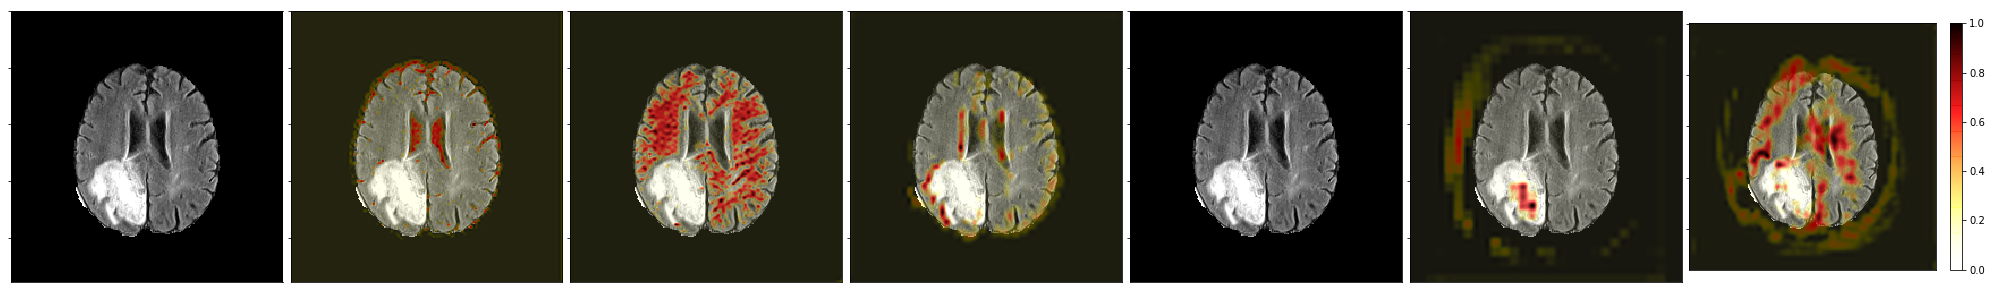

In [13]:
from BioExp.graphs.trails import EstimateTrails
from BioExp.helpers import utils

images = ['Brats18_CBICA_ASA_1', 'Brats18_CBICA_AMH_1', 'Brats18_CBICA_AQO_1']
for img in images:
    image, gt = utils.load_vol_brats('../BioExp/sample_vol/brats/{}'.format(img) , slicen=92)
    image = image[:, :, seq_map[seq]][:,:, None]

    metric = dice_label_coef # defined in helpers.losses
    GT = EstimateTrails(model, weights_path, graph, root_node, metric, ntrails=3)

    save_path = './LogsN/{}/Graphs/trails/{}'.format(seq, img)
    tr, td, V = GT.trails('Input', 'node_20', image, gt, save_path=save_path, visual=True)

In [9]:
from BioExp.graphs.trails import EstimateTrails
from BioExp.helpers import utils

images = ['Brats18_CBICA_ASA_1', 'Brats18_CBICA_AMH_1', 'Brats18_CBICA_AQO_1']
for img in images:
    image, gt = utils.load_vol_brats('../BioExp/sample_vol/brats/{}'.format(img) , slicen=92)
    image = image[:, :, seq_map[seq]][:,:, None]

    metric = dice_label_coef # defined in helpers.losses
    GT = EstimateTrails(model, weights_path, graph, root_node, metric, ntrails=3)

    save_path = './Logs/{}/Graphs/trails/{}'.format(seq, img)
    tr, td, V = GT.trails('Input', 'node_19', image, gt, save_path=save_path, visual=True)

[INFO: BioExp Concept Identification] Identified Concept node_4 in layer conv2d_5
[INFO: BioExp Concept Identification] Identified Concept node_8 in layer conv2d_7
[INFO: BioExp Concept Identification] Identified Concept node_13 in layer conv2d_9
[INFO: BioExp Concept Identification] Identified Concept node_14 in layer conv2d_11
[INFO: BioExp Concept Identification] Identified Concept node_19 in layer conv2d_13
[INFO: BioExp Trails]===== New trail =====
  (Input)  ->  (node_4)  ->  (node_8)  ->  (node_13)  ->  (node_14)  ->  (node_19)  
  (Input Image to a network)  ->  (Concave edge detector)  ->  (Corner keypoints all over the brain)  ->  (Anterior brain boundary and inner brain corner keypoints)  ->  (Lateral right hemispherical brain boundary)  ->  (Lateral left hemispherical brain boundary)  
[INFO: BioExp Concept Identification] Identified Concept node_4 in layer conv2d_5
[INFO: BioExp Concept Identification] Identified Concept node_8 in layer conv2d_7
[INFO: BioExp Concept Ident

In [ ]:
from BioExp.graphs.trails import EstimateTrails
from BioExp.helpers import utils

images = ['Brats18_CBICA_ASA_1', 'Brats18_CBICA_AMH_1', 'Brats18_CBICA_AQO_1']
for img in images:
    image, gt = utils.load_vol_brats('../BioExp/sample_vol/brats/{}'.format(img) , slicen=92)
    image = image[:, :, seq_map[seq]][:,:, None]

    metric = dice_label_coef # defined in helpers.losses
    GT = EstimateTrails(model, weights_path, graph, root_node, metric, ntrails=3)

    save_path = './Logs/{}/Graphs/trails/{}'.format(seq, img)
    tr, td, V = GT.trails('Input', 'node_21', image, gt, save_path=save_path, visual=True)

[INFO: BioExp Concept Identification] Identified Concept node_4 in layer conv2d_5
[INFO: BioExp Concept Identification] Identified Concept node_8 in layer conv2d_7
[INFO: BioExp Concept Identification] Identified Concept node_13 in layer conv2d_9
[INFO: BioExp Concept Identification] Identified Concept node_14 in layer conv2d_11
[INFO: BioExp Concept Identification] Identified Concept node_19 in layer conv2d_13
[INFO: BioExp Concept Identification] Identified Concept node_21 in layer conv2d_15
[INFO: BioExp Trails]===== New trail =====
  (Input)  ->  (node_4)  ->  (node_8)  ->  (node_13)  ->  (node_14)  ->  (node_19)  ->  (node_21)  
  (Input Image to a network)  ->  (Concave edge detector)  ->  (Corner keypoints all over the brain)  ->  (Anterior brain boundary and inner brain corner keypoints)  ->  (Lateral right hemispherical brain boundary)  ->  (Lateral left hemispherical brain boundary)  ->  (Left lateral tumor region)  
[INFO: BioExp Concept Identification] Identified Concept no

/home/pi/miniconda/envs/bioexp/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


[INFO: BioExp Concept Identification] Identified Concept node_4 in layer conv2d_5
[INFO: BioExp Concept Identification] Identified Concept node_8 in layer conv2d_7
[INFO: BioExp Concept Identification] Identified Concept node_13 in layer conv2d_9
[INFO: BioExp Concept Identification] Identified Concept node_14 in layer conv2d_11
[INFO: BioExp Concept Identification] Identified Concept node_19 in layer conv2d_13
[INFO: BioExp Concept Identification] Identified Concept node_21 in layer conv2d_15
[INFO: BioExp Trails]===== New trail =====
  (Input)  ->  (node_4)  ->  (node_8)  ->  (node_13)  ->  (node_14)  ->  (node_19)  ->  (node_21)  
  (Input Image to a network)  ->  (Concave edge detector)  ->  (Corner keypoints all over the brain)  ->  (Anterior brain boundary and inner brain corner keypoints)  ->  (Lateral right hemispherical brain boundary)  ->  (Lateral left hemispherical brain boundary)  ->  (Left lateral tumor region)  
[INFO: BioExp Concept Identification] Identified Concept no

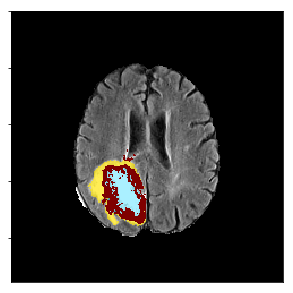

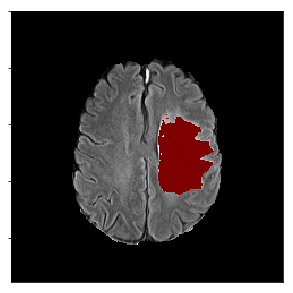

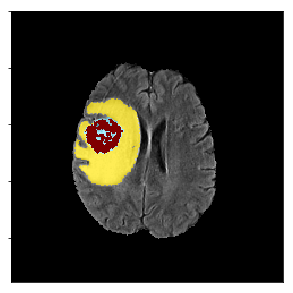

In [14]:
from BioExp.helpers import utils
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

images = ['Brats18_CBICA_ASA_1', 'Brats18_CBICA_AMH_1', 'Brats18_CBICA_AQO_1']

for i, img in enumerate(images):
    image, gt = utils.load_vol_brats('../BioExp/sample_vol/brats/{}'.format(img) , slicen=92)
    gt = (gt - np.min(gt))/(np.max(gt) - np.min(gt))
    image = image[:, :, seq_map[seq]][:,:, None]
    plt.figure(figsize=(5, 5))
    ax = plt.subplot(1, 1, 1)
    im = ax.imshow(np.squeeze(image), cmap='gray', vmin=0, vmax=1)                    
    im = ax.imshow(gt, cmap=utils.get_transparent_cmap('jet'), vmin=0, vmax=1)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    ax.tick_params(bottom='off', top='off', labelbottom='off' )
    plt.savefig('imgs_{}.png'.format(img), bbox_inches='tight')
    